In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.color import rgb2grey
from sklearn.feature_extraction import image
from skimage.filters import rank, threshold_otsu
from skimage.morphology import closing, square, disk
from skimage import exposure as hist, data, img_as_float
from skimage.segmentation import chan_vese
from skimage.feature import canny
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import pandas as pd
from scipy import ndimage

In [3]:
def load_images(paths):
    tmp=[]
    for path in paths:
        tmp.append(imread(path))
    return tmp

def plot_any(arr,title=''):
    plt.figure(figsize=(15,25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i+1)
        plt.title(title)
        plt.imshow(arr[i])

In [231]:
##edit the file name as needed
datadir = "/Users/binbinweng/Documents/community_college/UIUC/Computational_Photography/final_project/"

In [236]:
testing_fn = np.asarray(['2008_000337.jpg', '2008_002253.jpg', '2008_006749.jpg',
       '2008_008775.jpg', '2009_000098.jpg', '2009_002483.jpg',
       '2011_000547.jpg', '2011_004995.jpg', '2011_005511.jpg',
       '2012_003161.jpg']).astype('object')

In [238]:
#edit file name as needed
testing_fn = datadir+'testing/VOC2012/JPEGImages/'+testing_fn

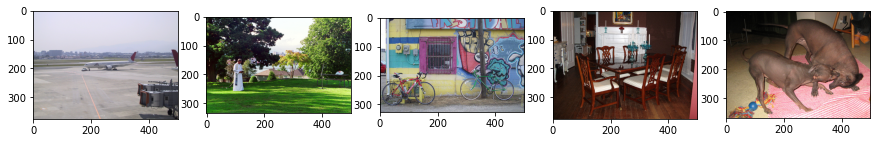

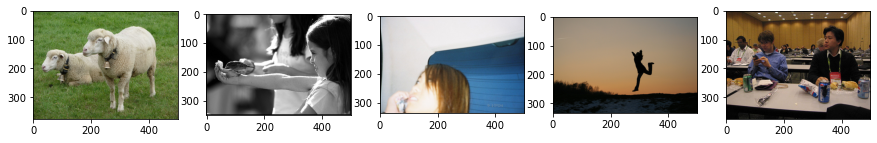

In [239]:
original_imgs = load_images(testing_fn)
plot_any(original_imgs[:5])
plot_any(original_imgs[5:])

In [23]:
def contrast_stretching(img):
    original = img.copy()
    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    img = cv2.LUT(img, table)
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.show()
    return img

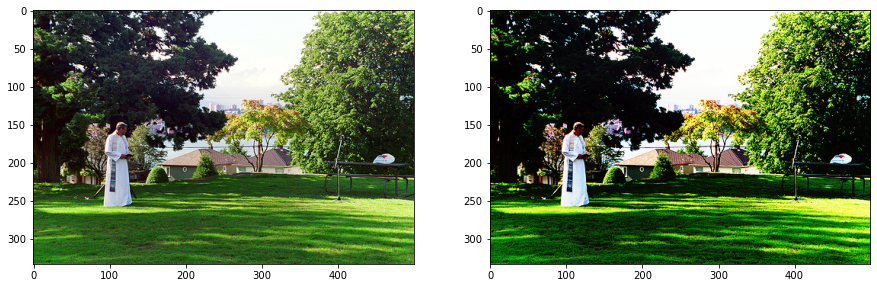

In [129]:
selected_img = original_imgs[1]
contrast_stretched_img = contrast_stretching(selected_img)

In [130]:
def elbow(img,k):
    hist = []
    for kclusters in range(1,k+1):
        km = KMeans(n_clusters = kclusters,init='k-means++',random_state=1).fit(img.reshape((-1,1)))
        hist.append(km.inertia_)
    
    plt.figure(figsize =(15,8))
    plt.grid()
    plt.plot(range(1,k+1),hist,'o-')
    plt.ylabel('Within-Cluster Sum of Square')
    plt.xlabel('k clusters')
    plt.title('Elbow')
    plt.show()
    
    return hist

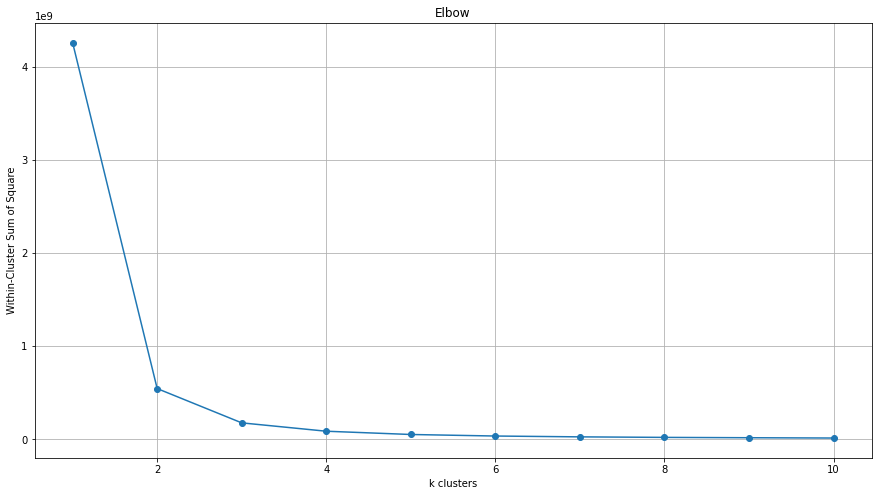

In [131]:
hist = elbow(contrast_stretched_img,10)

In [176]:
def select_k(hist):
    k = 0
    for i in range(len(hist)):
        if(hist[i] - hist[i+1] < 300000000):
            k = i+1
            break
    return k

In [133]:
k = select_k(hist)

In [134]:
def get_laplacian_pyramid_layer(img, n):
    G = img.copy()
    gp = [G]
    for i in range(n):
        G = cv2.pyrDown(G)
        gp.append(G)
    
    lp = [gp[n-1]]
    for i in range(n-1,0,-1):
        r=gp[i-1].shape[0]
        c=gp[i-1].shape[1]
        l = cv2.subtract(gp[i-1],cv2.pyrUp(gp[i])[:r,:c,:])
        lp.append(l)
    
    return lp[0]

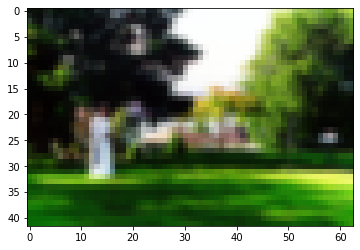

In [135]:
lap = get_laplacian_pyramid_layer(contrast_stretched_img, 4)
plt.imshow(lap)

In [217]:
def subtractive_clustering(img,k, ra):
    row = img.shape[0]
    col = img.shape[1] 
    reshaped_img = img.reshape((row*col,3))
    rb = 1.5*ra
    
    
    potential = [0.0]*(row*col)
    
    for i in range(row*col):
        Xi = reshaped_img[i]
        for j in range(row*col):
            Xj = reshaped_img[j]
            value = np.exp(-((Xi[0]-Xj[0])**2+(Xi[1]-Xj[1])**2+(Xi[2]-Xj[2])**2)/((ra/2)**2))
            potential[i] += value
    
    max_potential_value = max(potential)
    max_potential_index = potential.index(max_potential_value)
    cluster_index =[]
    cluster_index.append(max_potential_index)
    centroids = []
    centroids.append(reshaped_img[max_potential_index])
    
    for l in range(k-1):
        X = reshaped_img[max_potential_index]
        V=0
        for j in range(row*col):
            Xj = reshaped_img[j]
            value = np.exp(-((X[0]-Xj[0])**2+(X[1]-Xj[1])**2+(X[2]-Xj[2])**2)/((rb/2)**2))
            V += value
        for i in range(row*col):
            potential[i] = potential[i] - potential[max_potential_index]*V
        
        max_potential_value = max(potential)
        max_potential_index = potential.index(max_potential_value)
        cluster_index.append(max_potential_index)
        centroids.append(reshaped_img[max_potential_index])
        
    return cluster_index, centroids

In [212]:
cluster_index, centroids = subtractive_clustering(lap,k, 0.5)

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars


In [138]:
def my_KMeans(img,centroids,k):
    km = KMeans(n_clusters = k,init=centroids).fit(img.reshape((img.shape[0]*img.shape[1],3)))
    pic2show = km.cluster_centers_[km.labels_]/255.0
    cluster_pic = pic2show.reshape((img.shape))
    plt.imshow(cluster_pic)
    plt.show()
    
    return cluster_pic

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


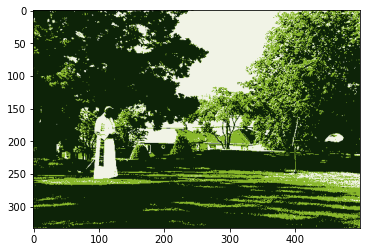

In [139]:
segmented_img = my_KMeans(contrast_stretched_img,np.asarray(centroids),k)

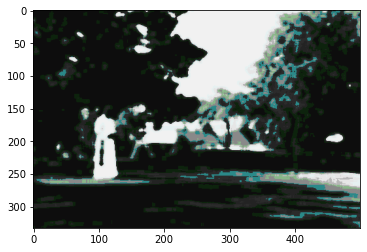

In [187]:
from scipy import ndimage, misc
result = ndimage.median_filter(segmented_img, size=7)
plt.imshow(result)
plt.show()

In [163]:
def rmse(r, t):
    # r is the original image, t is the segmented image
    score = np.sqrt((np.sum(r**2)/np.sum((r-t)**2))/(t.shape[1]*t.shape[2]*3))
    return score

def psnr(r, t):
    # r is the original image, t is the segmented image
    score = 10*math.log10((r.max())**2/(np.sqrt((np.sum(r**2)/np.sum((r-t)**2))/(t.shape[1]*t.shape[2]*3))))
    return score

In [164]:
rmse_score = rmse(selected_img,result)
psnr_score = psnr(selected_img,result)

In [165]:
rmse_score

0.001319694164505611

In [143]:
psnr_score

76.92607064553756

In [218]:
def image_segmentation(img):
    #contranst stretching image
    contrast_stretched_img = contrast_stretching(img)
    #determine value of k
    hist = elbow(contrast_stretched_img,10)
    k = select_k(hist)
    #laplacian pyramid to downsize image
    lap = get_laplacian_pyramid_layer(contrast_stretched_img, 4)
    plt.imshow(lap)
    plt.show()
    #subtractive clustering to select initial k centroids
    cluster_index, centroids = subtractive_clustering(lap,k, 0.3)
    #K-Means clustering on the contrast stretched image with the selected initial k centroids
    segmented_img = my_KMeans(contrast_stretched_img,np.asarray(centroids),k)
    #apply median filter to segmented_image to remove noise
    from scipy import ndimage, misc
    result = ndimage.median_filter(segmented_img, size=7)
    plt.imshow(result)
    plt.show()
    #calculate rmse and psnr score
    rmse_score = rmse(img,result)
    psnr_score = psnr(img,result)
    
    return result,rmse_score,psnr_score,k
    

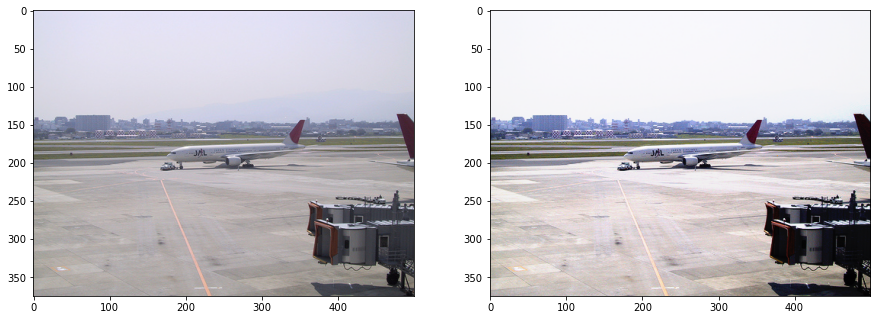

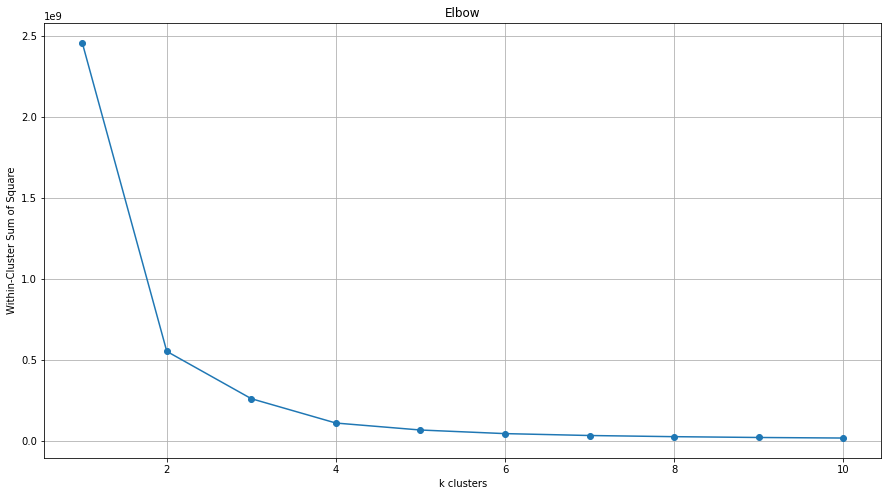

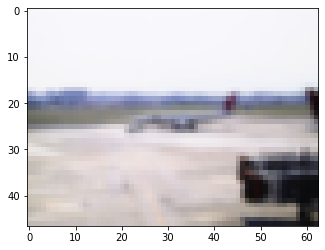

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


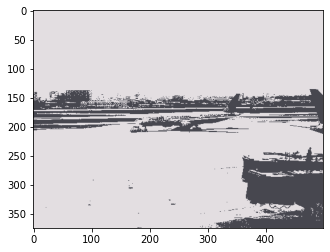

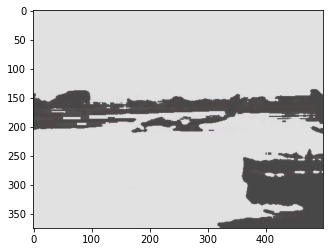

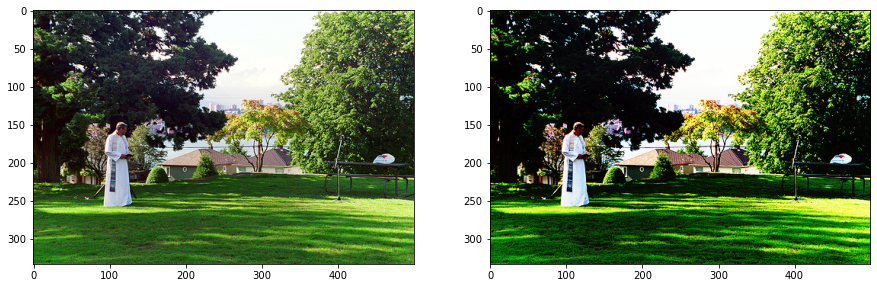

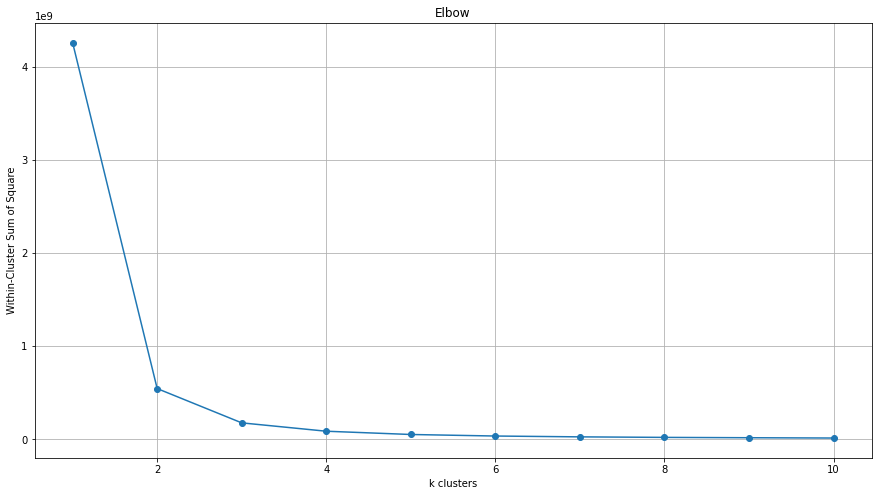

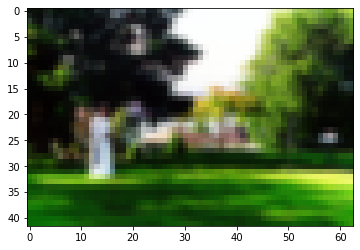

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


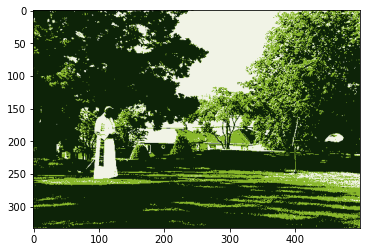

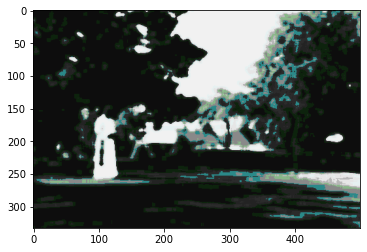

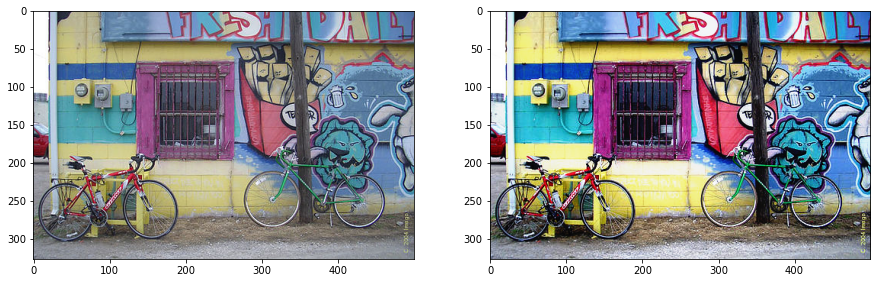

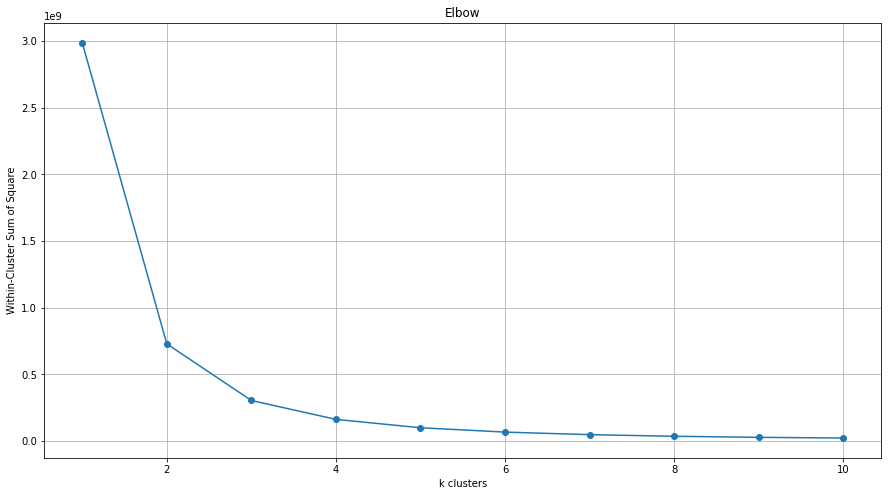

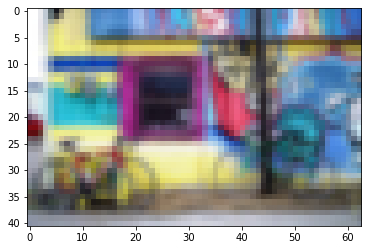

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


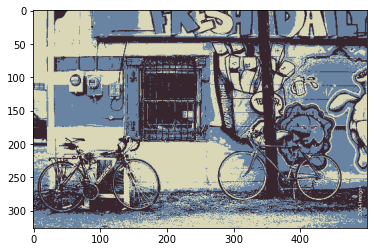

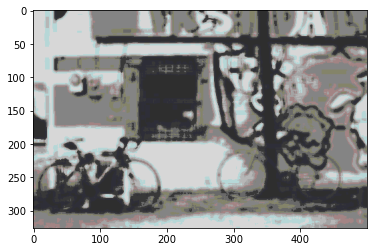

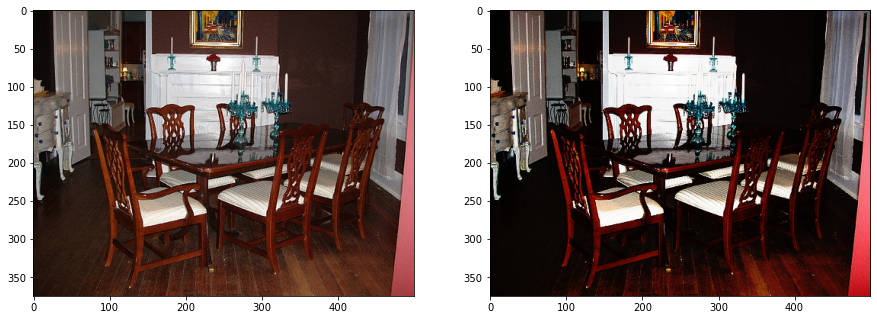

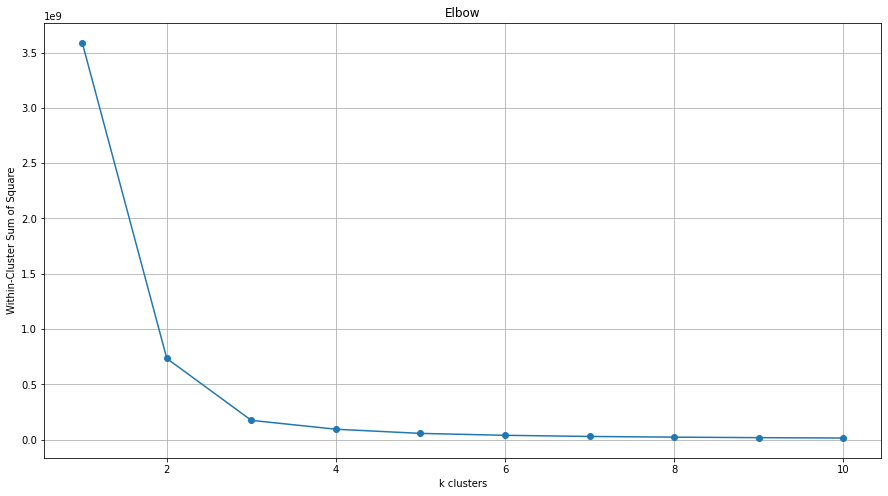

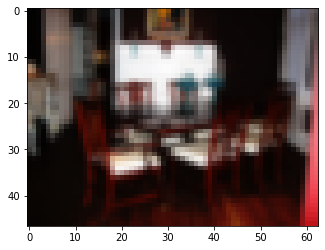

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


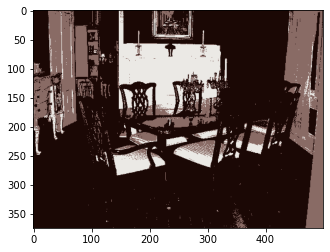

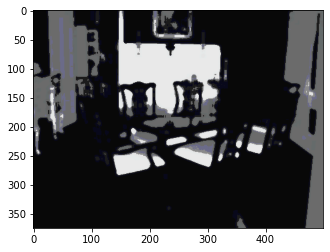

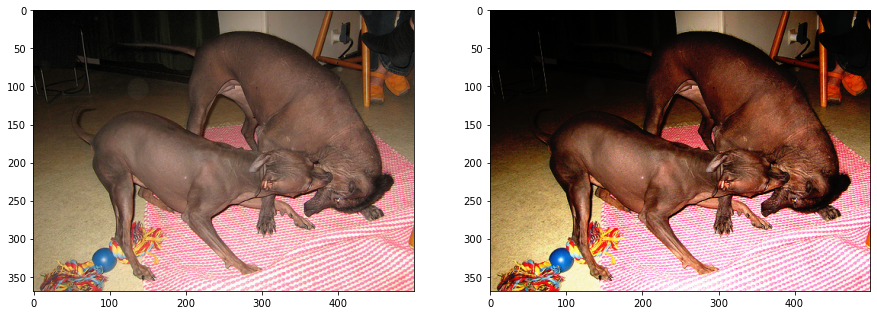

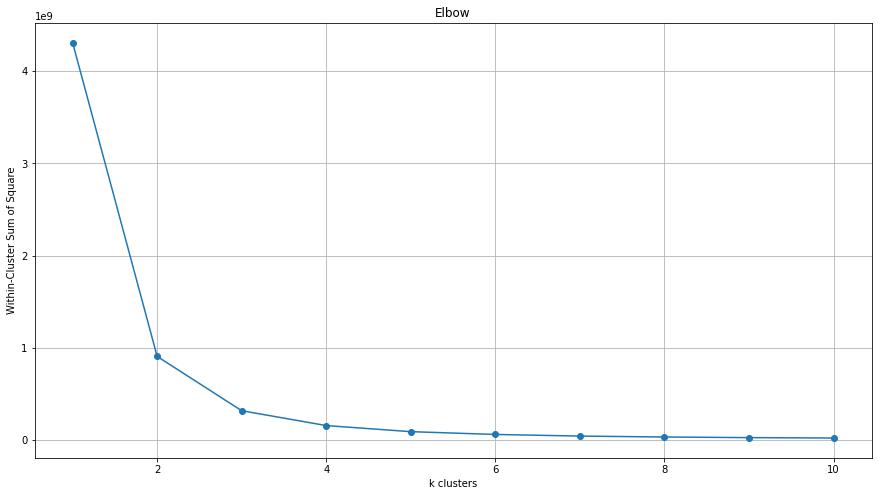

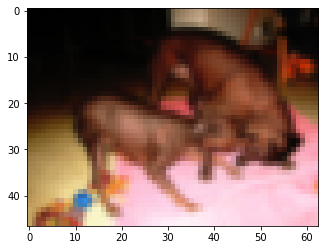

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


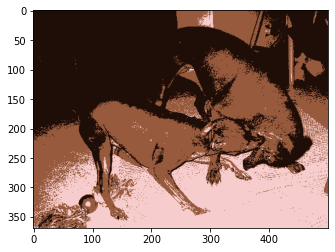

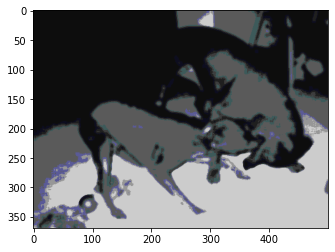

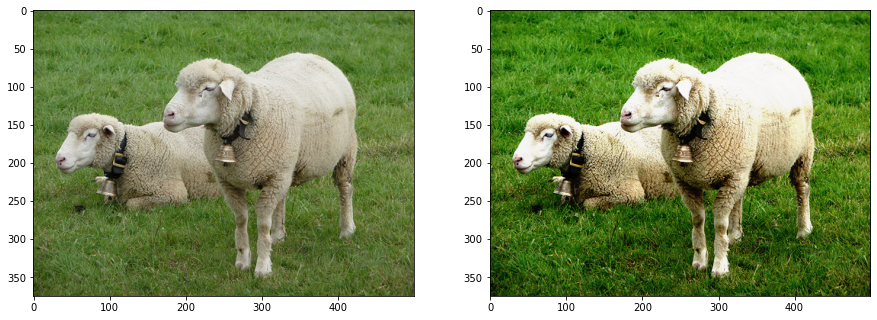

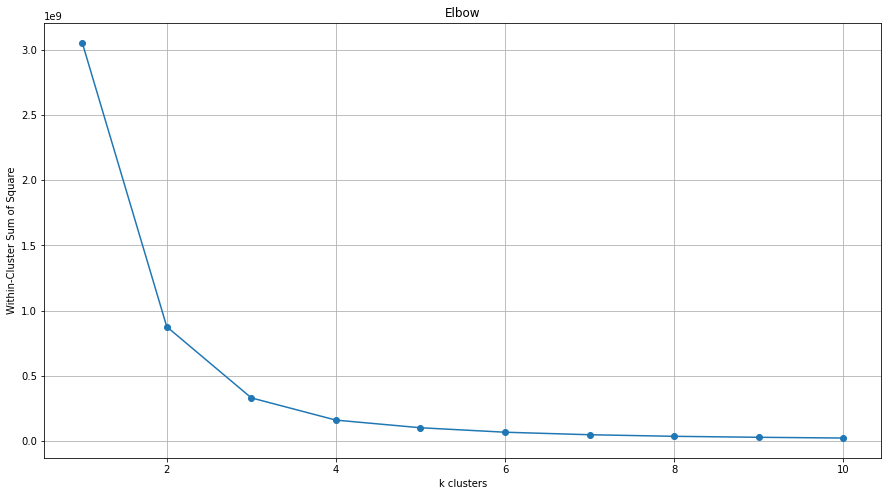

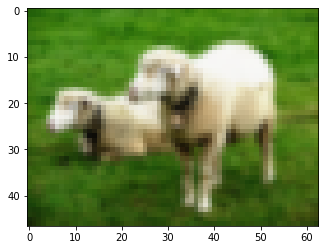

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


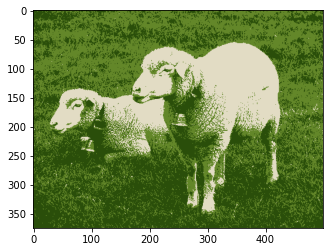

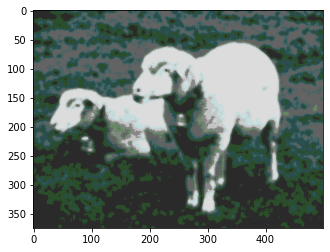

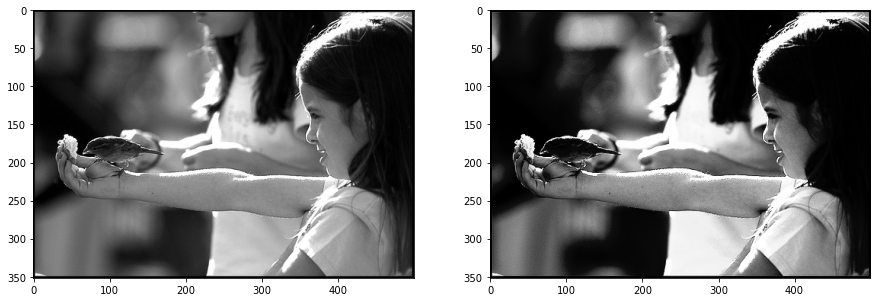

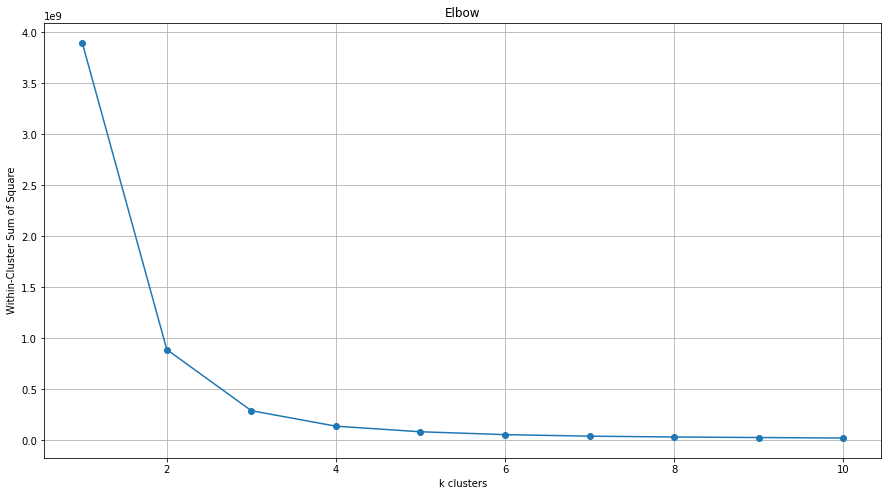

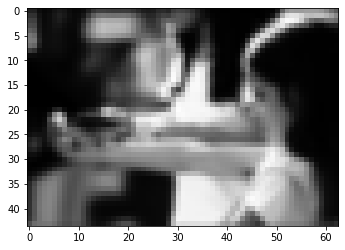

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


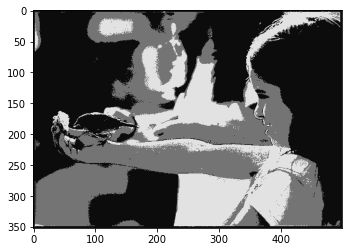

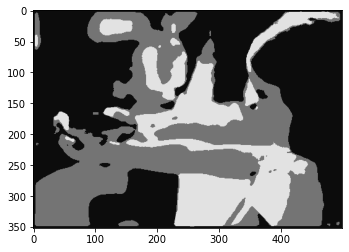

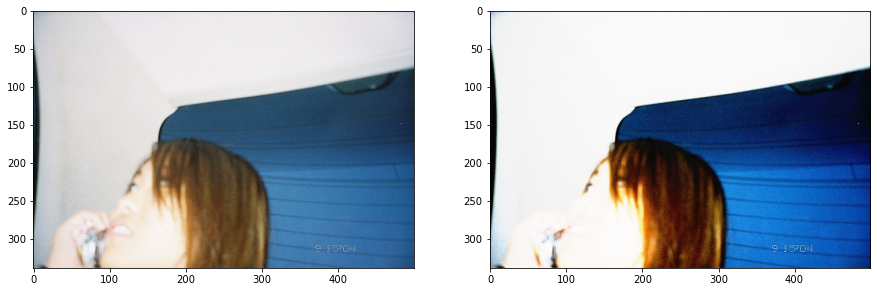

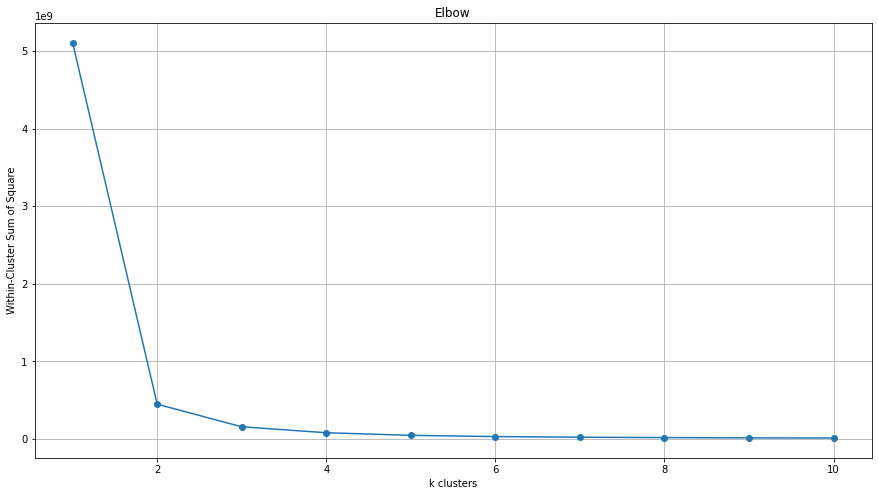

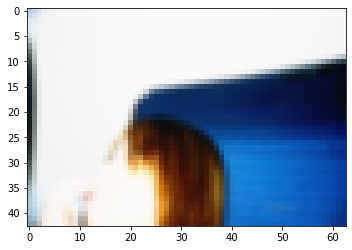

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


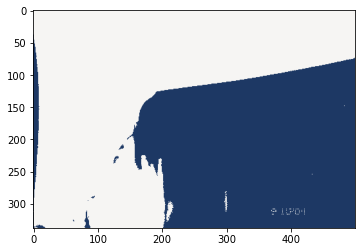

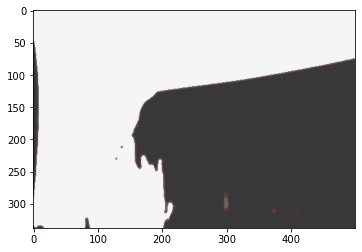

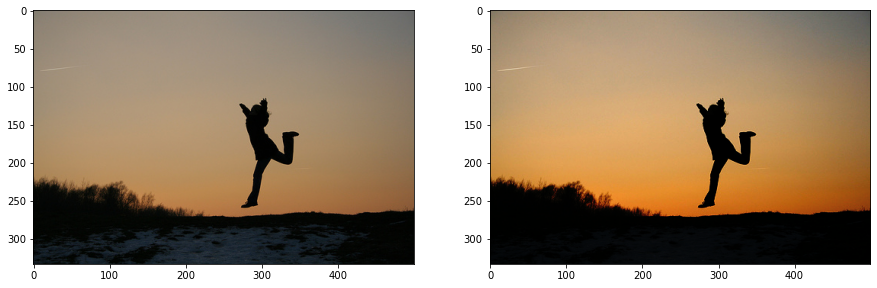

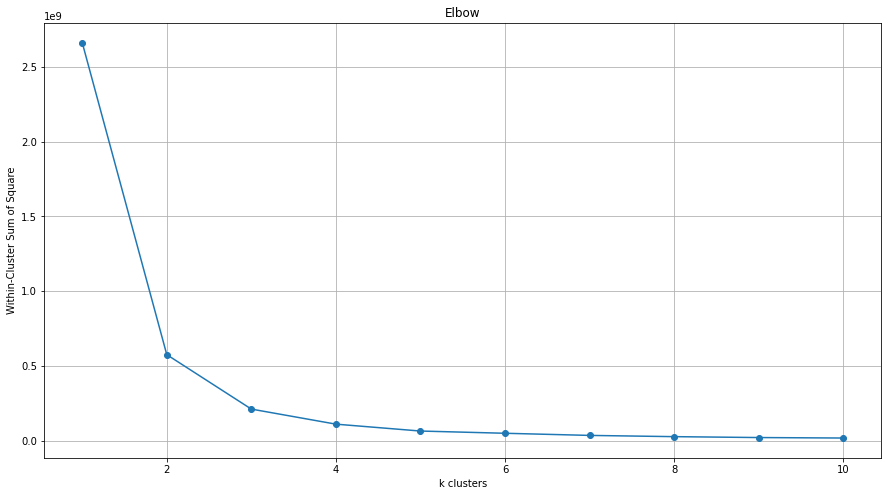

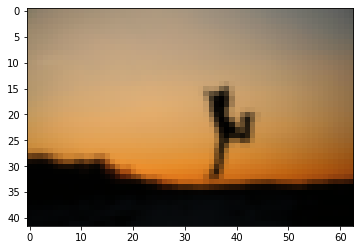

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


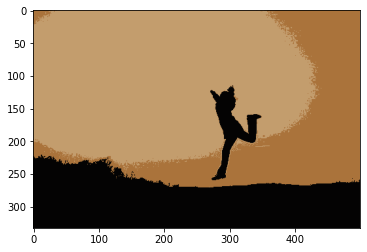

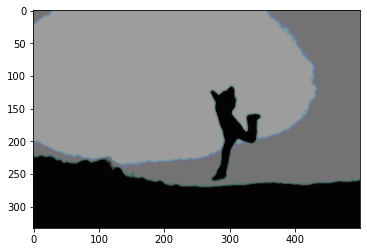

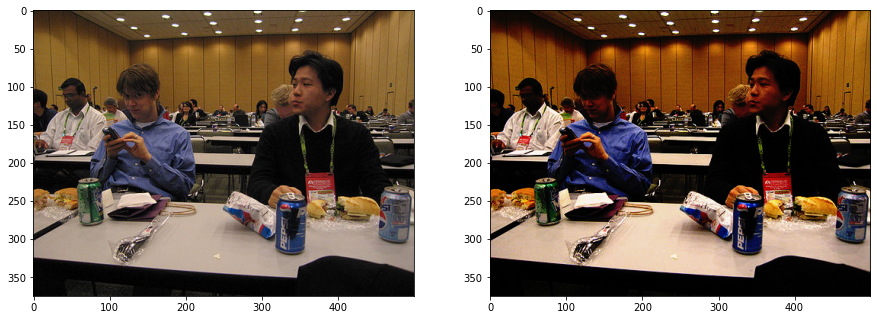

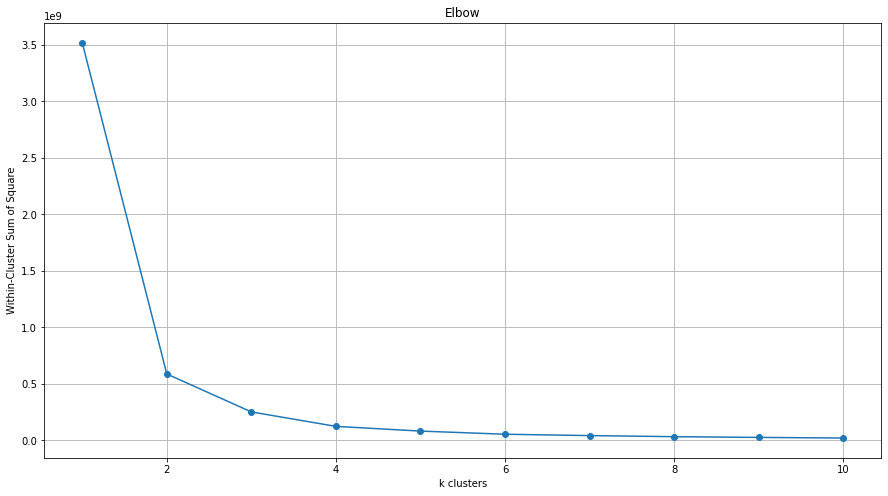

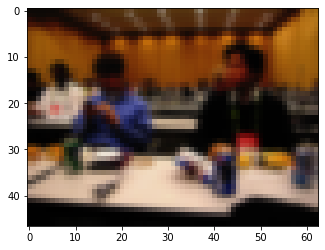

/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/binbinweng/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


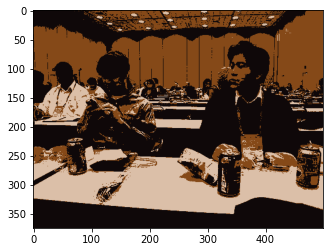

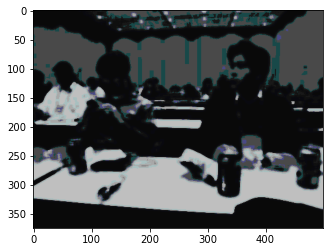

In [219]:
rmse_scores = []
psnr_scores = []
result_imgs = []
numOfClusters = []
for i in range(len(original_imgs)):
    selected_image = original_imgs[i]
    result_image, rmse_score, psnr_score, kclusters = image_segmentation(selected_image)
    
    rmse_scores.append(rmse_score)
    psnr_scores.append(psnr_score)
    result_imgs.append(result_image)
    numOfClusters.append(kclusters)

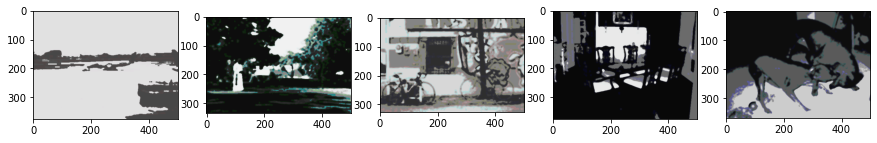

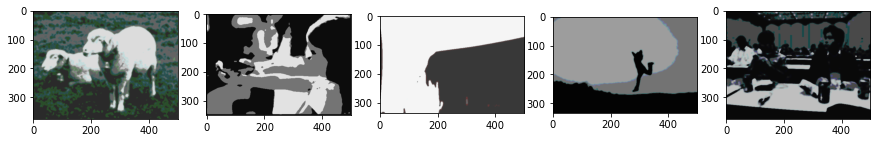

In [221]:
plot_any(result_imgs[:5])
plot_any(result_imgs[5:])

In [181]:
rmse_scores

[0.0008632477532763034,
 0.001319694164505611,
 0.0010944489255087827,
 0.0015798306313598688,
 0.0011903841956730527,
 0.0013038372500556643,
 0.0012123745628883262,
 0.0008966939400014445,
 0.0011730843095534146,
 0.0014895897998874904]

In [182]:
psnr_scores

[78.76944904157422,
 76.92607064553756,
 77.73884861649444,
 76.14469830754324,
 77.37393208608266,
 76.97856976384534,
 77.29443545109909,
 78.60436126129404,
 76.11559003704501,
 76.40013671094596]

In [197]:
for i in range(len(result_imgs)):
    cv2.imwrite('segmented_image_%i.jpg'%i,result_imgs[i]*255)